"In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits."

"For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task."

In [46]:
#import the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(79728)
%matplotlib inline
%whos

Variable           Type                          Data/Info
----------------------------------------------------------
Lambda             float                         0.0
NamespaceMagics    MetaHasTraits                 <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
X                  ndarray                       5000x401: 2005000 elems, type `float64`, 16040000 bytes (15.29693603515625 Mb)
a                  ndarray                       12: 12 elems, type `int64`, 96 bytes
cost_function      function                      <function cost_function at 0x1112a98c8>
data               dict                          n=5
get_ipython        function                      <function get_ipython at 0x10fe59378>
getsizeof          builtin_function_or_method    <built-in function getsizeof>
gradient           function                      <function gradient at 0x1112a9620>
h                  function                      <function h at 0x1112a97b8>
i                  int                   

I added the line magic whos here. It shows the variables and functions you have defined as a list when you want to get information about what you defined

We need to import a matlab file. scipy has a library for this.

In [2]:
import scipy.io as sio
data = sio.loadmat('../data/ex3data1.mat')
data

{'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

This is a dictionary file and X, y are what we are looking for. Let's define and extract them.

In [3]:
X = np.float64(data["X"])
y = np.float64(data["y"])
X.shape, y.shape

((5000, 400), (5000, 1))

It is a good idea to check the type of your data and convert it to float apparently. The reason for this is, when you preserve y as an integer vector, taking the negative of it will do interesting tricks on your data. Python will convert y to a 8bit integer vector, which has no representation for negative numbers. Then when you take negative of say 2, it will convert it to 256 - 2 = 254! 

What we have here is 5000 thousand samples. Each row is an array of numbers that represent brightness level of pixels. Each square consist of $20x20=400$ pixel. We will insert a column of one as the constant value.

In [4]:
X = np.insert(X, 0, 1, axis=1)
X.shape
#We'll have 401 columns as a result

(5000, 401)

Let's check how many there are of each element:

In [5]:
pd.Series(y.flatten()).value_counts()

9.0     500
8.0     500
7.0     500
6.0     500
5.0     500
4.0     500
3.0     500
2.0     500
1.0     500
10.0    500
dtype: int64

Now let's look at how the data is structured very briefly. As expected the edges of boxes are empty. The zigzags in the middle mostly represent the top and the bottom pixels which are empty. They happen around the multiples of 20.

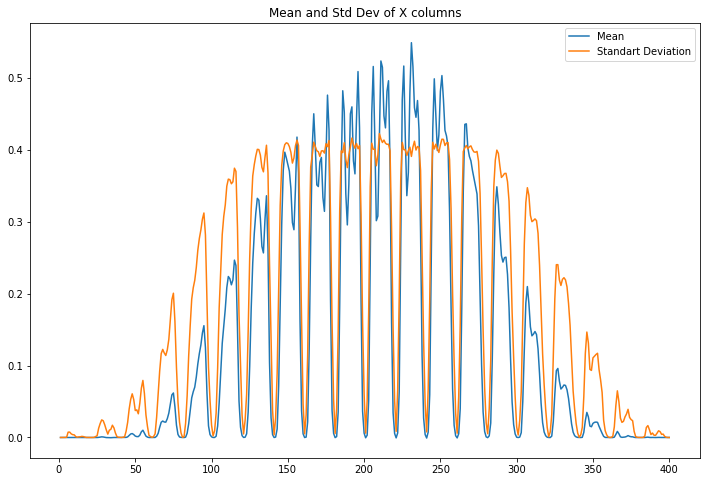

In [6]:
plt.figure(figsize=(12, 8))

ser_mean = np.asarray([np.mean([X[:, i]]) for i in range(1, 401)])
ser_sd = np.asarray([np.std([X[:, i]]) for i in range(1, 401)])
plt.plot(np.arange(1, 401), ser_mean, label = "Mean")
plt.plot(np.arange(1, 401), ser_sd, label = "Standart Deviation")
plt.legend()
plt.title("Mean and Std Dev of X columns");

Finally, let's illustrate some of the data we have. As we know from the description of the dataset, each entry in X consist of 400 numbers, each number illustrating the degree of darkness of each pixel. We can actually map this to a graph, or pic if you'd like through imshow function in matplotlib library. 

We'll first draw 36 random entry to show. Then transform the one dimensional arrays of info into 20x20 square matrix. Finally we'll plot the each data row with a for loop.

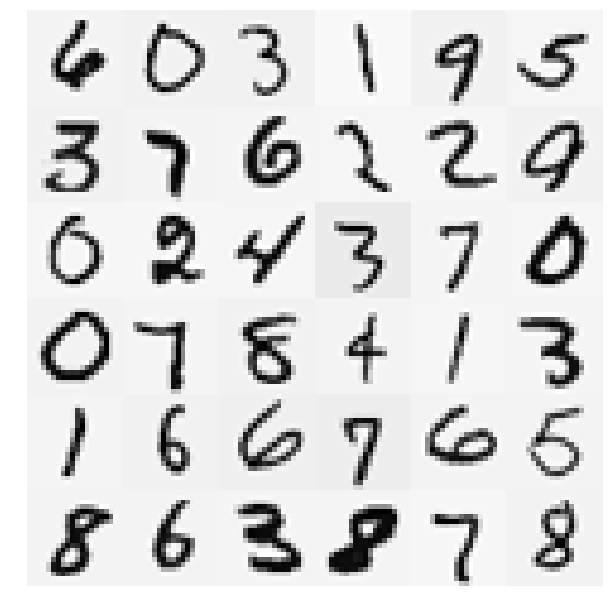

In [71]:
num_show = np.random.randint(0, 5001, 36)

plt.figure(figsize=(8, 8))

for i in range(1, 37):
    some_digit = X[num_show[i-1]][1:401]
    some_digit_image = some_digit.reshape(20, 20).T
    #We appearantly need to transpose the matrix
    
    plt.subplot(6, 6, i)
    plt.imshow(some_digit_image, cmap = plt.cm.binary,
           interpolation="nearest")
    plt.axis("off")
    plt.subplots_adjust(left=0, right = 1, bottom=0, top=1, wspace=0, hspace=0)

**Cost Function**

Let's try to write down the cost function that we will try to minimize for logistic regression. We will use the cost function from "Logistic Regression with regularization". We already vectorized our logistic cost function there.

First define the Hypothesis function

In [7]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def h(theta, X):
    """
    Hypothesis Function where
    X is an n x k dimensional array of explanatory variables
    theta is an one dimensional k elements vector
    Result will be one dimensional vector of n variables
    """
    return sigmoid(np.dot(X, theta))

Now the cost function. One thing to note here is that we keep our theta variable as a flat, one dimensional array. That's because we need to use scipy optimization libraries. It needs flattened input.

In [8]:
def cost_function(theta, Lambda, X, y):
    """
    This is a cost function that returns the cost of theta given X and y
    X is an n x k dimensional array of explanatory variables
    y is an array with n elements of explained variables. I flatten it no matter what its shape is
    theta is a vector with k elements of multipliers for linear function
    """
    #Let's write this function without the regularization
    item1 =  - y.flatten() * np.log(h(theta, X))
    item2 = (1 - y.flatten()) * np.log(1 - h(theta, X))
    item3 = (Lambda/(2*X.shape[0]) ) * np.sum(np.power(theta, 2)[1:]) 
    #Starting from the second element as the first theta will not be punished 
    return np.sum(item1 - item2) / (X.shape[0]) + item3


In [9]:
Lambda = 0.0
#theta = np.random.rand(X.shape[1]) - 0.5
theta = np.zeros(X.shape[1])

How about gradient function? We already took care of it too. It has already been vectorized as well. 

In [10]:
def gradient(theta, Lambda, X, y):
    """
    This function will take in theta value and calculate the gradient 
    descent values.
    X is an n x k matrix of explanatory variables
    y is a n sized array of explained variables
    theta is a vector with k elements of multipliers for linear function
    """
    #Let's try this function without regularization
    errors = h(theta, X) - y.flatten()
    #errors will be calculated more than once, so let's do it once and store it
    correction2 = (Lambda/X.shape[0]) * theta
    correction2[0] = 0.0 #First element will not be part of regularization
    correction = np.sum(errors.reshape((X.shape[0], 1)) * X, axis=0) * (1.0 / X.shape[0])
    return correction + correction2


##### **One vs all Classification**

We will apply one vs all classification. What it does is that it estimates the probability function separately for each unique value of y. We will actually estimate the probability through hypothesis function $h_\theta(X)$ and assign to highest value. 

This means transforming y vector for every value of y. For example for value 5, we will call y = 1 if y = 5 originally, y = 0 otherwise. We will do this for each value between 0-9. 

Let's try it for y = 5.

In [11]:
y_flattened = y.flatten() #easier to work with one dimensional arrays
#Find where y != 5 and mark them equal to zero: 
y_flattened[np.where(y_flattened != 5.0)] = 0.0
#Find where y == 5 and mark them equal to zero: 
y_flattened[np.where(y_flattened == 5.0)] = 1.0

Now let's see if we had a successful transformation:

In [12]:
pd.Series(y_flattened).value_counts()

0.0    4500
1.0     500
dtype: int64

Let's try to optimize the function and find the $\theta$s. I have tried many different methods and the one that works well is SLSQP. You can google it to see how it works. 

In [236]:
Lambda = 0.0
theta = np.zeros(X.shape[1])
result = opt.minimize(fun=cost_function, method='SLSQP', 
                      jac = gradient, x0=theta, args=(Lambda, X, y_flattened.reshape((X.shape[0], 1))), 
                      options={'maxiter':1000})


Let's write the function that would optimize our cost function and find the relevant $\theta$s for all values of y. 

In [231]:
def onevsall(X, y, Lambda = 0.0):
    results = []
    thetas = []
    successes = []
    
    for i in range(1, 11):
        theta = np.zeros(X.shape[1])
        #define the initial theta
        y_flattened = y.flatten()#easier to work with one dimensional arrays
        #Find where y != i and mark them equal to zero: 
        y_flattened[np.where(y_flattened != float(i))] = 0.0
        #Find where y == i and mark them equal to zero: 
        y_flattened[np.where(y_flattened == float(i))] = 1.0
        #optimization routine
        result = opt.minimize(fun=cost_function, method='SLSQP', 
                      jac = gradient, x0=theta, args=(Lambda, X, y_flattened.reshape((X.shape[0], 1))), 
                      options={'maxiter':1000})
        results.append(result)
        thetas.append(result['x'])
        successes.append(result['success'])
    
    return results, thetas, successes

In [232]:
res, thet, succes = onevsall(X, y)

/Users/alperen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/alperen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


'thet' contains all the multipliers for logistic regression

Let's see if all the loops successfully converged:

In [237]:
succes

[True, True, True, True, True, True, True, True, True, True]

Let's calculate the probabilities for each class.

In [256]:
#convert theta list into numpy array
thetas = np.array(thet).T
thetas.shape

(401, 10)

In [265]:
Probabilities = h(thetas, X)
Probabilities.shape

(5000, 10)

Probabilites is an 2d array where you have 10 entries for each 5000 entries. You may think that this is like a matrix, each row correspond to an entry and each column correspond to the probability of that entry is that particular given number. But my advice is not to think arrays like matrix, but stacks of arrays, which are one dimensional vectors. 

Now let's locate each of the argument maximizing location of probability within its probability array. 

In [287]:
Prob_argmax = np.argmax(Probabilities, axis=1)

Let's check the distribution of values as well:

In [286]:
pd.Series(Prob_argmax.flatten()).value_counts()

6    508
0    506
9    502
3    501
5    500
8    500
1    499
4    497
7    495
2    492
dtype: int64

It is looking pretty good but it does not mean that our guesses correspond to the correct values. We need to make sure that our guesses are correct. 

Because of the way I have arranged the sequence of calculating $\theta$, here I have the following situation: 0 in images, which correspond to 10 in the dataset here correspond to 9! 1 in the dataset correspond to 0; 2 to 1; 3 to 2 and so on. Good news is that, I can add one to each number and it will solve my problem

In [288]:
Prob_argmax += 1

Finally let's check the prediction error:

In [297]:
total_corrects = np.sum( (y.flatten() == np.float64(Prob_argmax)) )
total_dpoints = X.shape[0]

accuracy_rate = total_corrects/total_dpoints
accuracy_rate

0.9698

We have an accuracy rate of 97%. In the exercise instruction they have provided, they had 94.5%. Our optimization method(i.e. luck) was better apparently.  Not bad!